# Libraries

In [72]:
import time
import copy

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from mealpy import FloatVar, PSO
from mealpy.utils.problem import Problem
from mealpy.utils.problem import FloatVar

from scipy.optimize import root_scalar

from mealpy.swarm_based import PSO
from mealpy.utils.problem import FloatVar
import time


# Experimental data

In [73]:
df_exp = pd.read_excel('Experimental_data.xlsx', sheet_name='Fitting Data')
t_exp = df_exp['Time (Hours)']
X_exp = df_exp['Biomass (g/L)']
C_exp = df_exp['Glycerol (g/L)']
N_exp = df_exp['Ammonia (g/L)']
ph_exp = df_exp['pH']



# Parameters

In [74]:
# Original parameters
params_values = {'t_lag': 7,
      'k_C': 0.3828,
      'k_N': 1.0027e-4, 
      'Y': {'X_C': 0.484,
      'X_N': 21.575, 
      'X_CO2': 0.3687,
      'X_O2' : 1.352}, 
      'Xmax': 1.4462,  
      'mu_max': 0.19,
      'k_d': 0.001, 
      'pH': {'pka1': 6.86, # pKa of KH2PO4
            'pka2': 3.13,  # pka of C6H8O7
            'pka3': 4.76,  # pka of (C6H7O7)-
            'pka4': 6.40,  # pka of (C6H6O7)2-
            'pka5': 9.25,  # pka of NH3
            'pka6': 14.15, # pka of C3H8O3
            'pka7': 6.35,  # pka of CO2
            'pka8': 10.33, # pka of (HCO3)-
            'pka9': 14,    # pka of H2O
            'conc': {'KH2PO4': 2.18,
                  'C6H8O7': 2},
            'LL': 3.4687,
            'UL': 7.4,
            'alk': 7.2},
      'I_val': 4.0413,
      'pH_M': [0, 14],
      'O2_sat' : 0.007267,
      'k_La' : 86.26,
      'k_O' : 0.0045} 

P_og =[ params_values['pH']['UL'],params_values['Xmax']] #,params_values['Y']['X_C'],params_values['mu_max'],params_values['I_val'],,params_values['Y']['X_N']
print(P_og)


[7.4, 1.4462]


# Equations and Solving

In [75]:
def DAE_system_CasADi_O2(t, vars, z_algebraic, p, params_values):

      
      X, C, N, CO2, O = vars[0], vars[1], vars[2], vars[3], vars[4]
      w = z_algebraic[0] 

      UL = p[0] #params_values['pH']['UL']
      Xmax = p[1] #params_values['Xmax']#
      Y_X_C =params_values['Y']['X_C'] #p[2] #
      mu_max =params_values['mu_max']# p[3] #
      
      ival = params_values['I_val']#p[4] #
      Y_X_N = params_values['Y']['X_N']#p[5] #
      
      
      
      LL = params_values['pH']['LL']  
      Iph = ca.exp((ival * ((w - UL) / (UL - LL))) ** 2)

      # Specific growth rate
      mu = (mu_max
            * (1 - ca.exp(-t / params_values['t_lag'])) 
            * (C / (C + params_values['k_C'])) 
            * (N / (N + params_values['k_N'])) 
            * (O / (O + params_values['k_O']))
            * (1 - (X / (Xmax))) 
            * Iph)

      ka7 = 10 ** (-params_values['pH']['pka7'])

      # Differential equations
      dXdt   = (mu- params_values['k_d']) * X                                                                   # Biomass
      dCdt   = - (mu / Y_X_C) * X                                                                               # Glycerol
      dNdt   = - (mu / Y_X_N) * X                                                                               # Ammonia
      dCO2dt = ((mu / params_values['Y']['X_CO2']) * X) - ka7 * (CO2 / (((10 ** -w) / ka7) + 1))                # CO2
      dOdt   = params_values['k_La'] * (params_values['O2_sat'] - O) - (mu / params_values['Y']['X_O2']) * X    # O2

      return ca.vertcat(dXdt, dCdt, dNdt, dCO2dt, dOdt)

# Ajuste de parametros

In [76]:
param_names = ['UL','Xmax'] # ,'Y["X_C"]' ,'mu_max', 'I_val',, 'Y["X_N"]'  
#param_names = ['mu_max', 'UL', 'Y["X_C"]', 'Xmax', 'Y["X_N"]', 'I_val']
lb = [6, 1] #,0.1, 0.1, 3, , 20
ub = [7 , 1.2] #,1.0, 1.0, 5, , 23


In [77]:
def simulate_model(p_vars, x0, params_values):
    # Symbolic variables
    t = ca.MX.sym('t')
    x = ca.MX.sym('x', 5)  # [X, C, N, CO2, O2]
    z = ca.MX.sym('z')     # [pH]

    # Systems's differential equations
    dxdt = DAE_system_CasADi_O2(t, x, z, p_vars, params_values)

    # Algebraic equation
    # Parameters
    ka1 = 10 ** (-params_values['pH']['pka1'])  # KH2PO4
    ka2 = 10 ** (-params_values['pH']['pka2'])  # C6H8O7
    ka3 = 10 ** (-params_values['pH']['pka3'])  # (C6H7O7)-
    ka4 = 10 ** (-params_values['pH']['pka4'])  # (C6H6O7)2-
    ka7 = 10 ** (-params_values['pH']['pka7'])  # CO2
    ka9 = 10 ** (-params_values['pH']['pka9'])  # H2O

    H = 10 ** (-z) 

    # Concentration of charges according to H+ ions
    KHPO4 = params_values['pH']['conc']['KH2PO4'] / ((H / ka1) + 1)
    C6H5O7 = params_values['pH']['conc']['C6H8O7'] / ((H ** 3 / (ka2 * ka3 * ka4)) + (H ** 2 / (ka3 * ka4)) + (H / ka4) + 1)
    C6H6O7 = (H / ka4) * C6H5O7
    C6H7O7 = (H / ka3) * C6H6O7
    HCO3 = x[3] / ((H / ka7) + 1)
    OH = ka9 / H

    f_z = OH + HCO3 + KHPO4 + (3 * C6H5O7) + (2 * C6H6O7) + C6H7O7 - params_values['pH']['alk'] - H
    f = ca.Function('f', [t, x, z], [dxdt])
    t_values = t_exp 
    
    dae = {'t': t, 'x': x, 'z': z, 'ode': f(t,x,z), 'alg': f_z}
    integrator = ca.integrator('integrator', 'idas', dae, {'grid': t_values, 'output_t0': True})

    
    sol_casadi = integrator(x0=x0[:-1], z0=x0[-1])
    return sol_casadi 


In [78]:
X0 = X_exp[0]  
c0 = C_exp[0] 
n0 = N_exp[0] 
co20 = 0.439 / 1000
o20 = 0.007267
z0 = ph_exp[0]  
x0 = np.array([X0, c0, n0, co20, o20, z0])

# ajuste datos normales

In [79]:
def cost_function(p_vars):
    try:
        sol = simulate_model(p_vars,x0, params_values)

        
        x = sol['xf'].full().T
        z = sol['zf'].full().T
        X = x[:, 0]
        C = x[:, 1]
        N = x[:, 2]
        CO2 = x[:, 3]
        pH = z[:, 0]
        H = 10 ** (-pH)

        df_results = pd.DataFrame({
            'X': X,
            'C': C,
            'N': N,
            'CO2': CO2,
            'pH': pH,
            'H': H,
        })



        X_sim, C_sim, N_sim, CO2_sim, pH_sim = df_results['X'], df_results['C'], df_results['N'], df_results['CO2'], df_results['pH']

        err = np.sum((X_sim - X_exp)**2) + np.sum((C_sim - C_exp)**2) + np.sum((N_sim - N_exp)**2) + np.sum((pH_sim - ph_exp)**2)
        return [err]
    except:
        return [1e6]  


In [80]:
problem = {
    "obj_func": cost_function,
    "bounds": FloatVar(lb=lb, ub=ub),
    "minmax": "min"
}

pso = PSO.OriginalPSO(epoch=200, pop_size=50, c1=2, c2=1.5, w=0.5)
start = time.perf_counter()
g_best = pso.solve(problem)
end = time.perf_counter()

print("Mejores parámetros encontrados:", g_best.solution)
print("Error mínimo:", g_best.target.fitness)
print(f"Tiempo de optimización: {end - start:.2f} s")

p_vars = g_best.solution
p_norm = p_vars


2025/07/07 09:01:12 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving single objective optimization problem.


2025/07/07 09:01:13 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 1.41518330922158, Global best: 1.41518330922158, Runtime: 0.38957 seconds
2025/07/07 09:01:14 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 1.3887561722092536, Global best: 1.3887561722092536, Runtime: 0.37246 seconds
2025/07/07 09:01:14 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 1.3821537177611156, Global best: 1.3821537177611156, Runtime: 0.37465 seconds
2025/07/07 09:01:14 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 1.3792479569452207, Global best: 1.3792479569452207, Runtime: 0.37106 seconds
2025/07/07 09:01:15 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 1.3771353320662683, Global best: 1.3771353320662683, Runtime: 0.35059 seconds
2025/07/07 09:01:15 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6

Mejores parámetros encontrados: [6.40879571 1.2       ]
Error mínimo: 1.373795026600689
Tiempo de optimización: 74.58 s


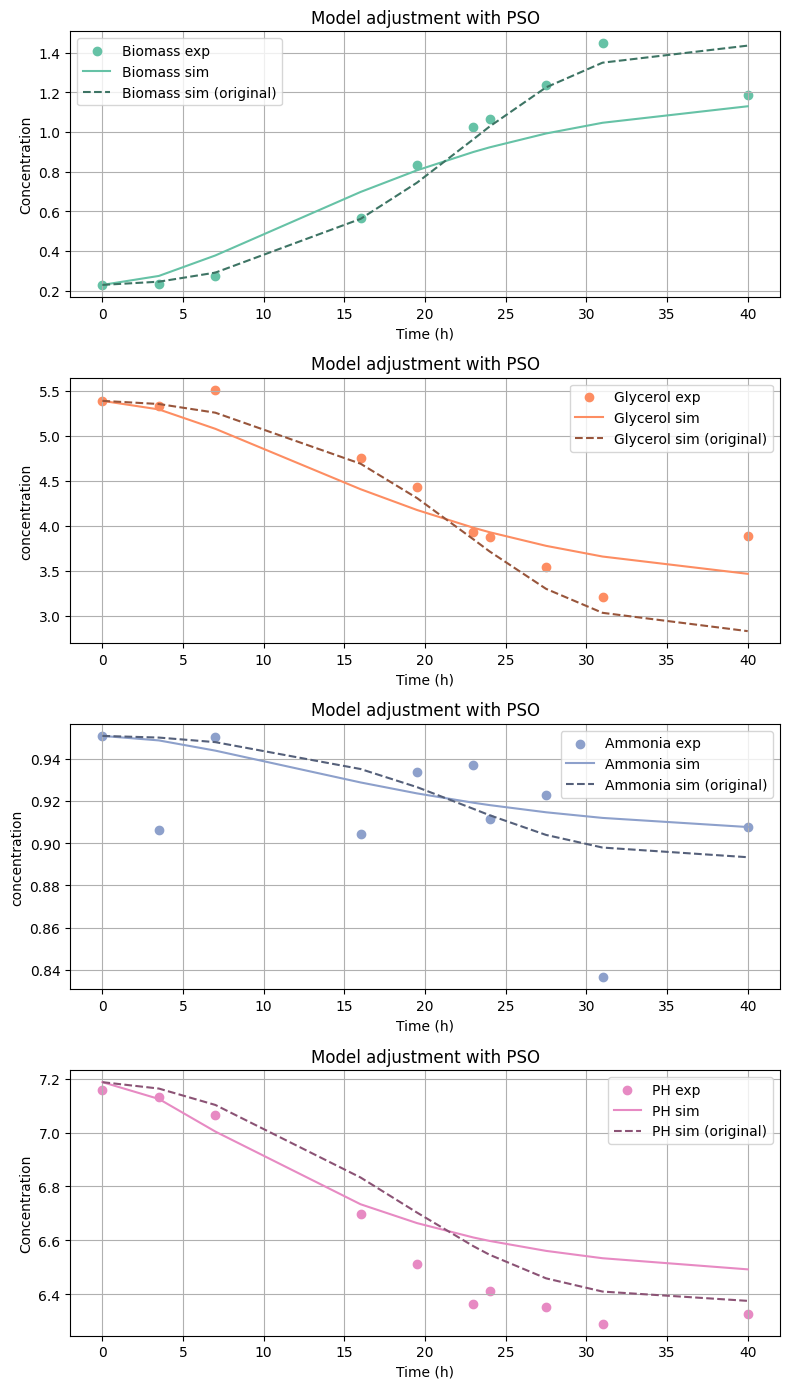

In [81]:
sol = simulate_model(p_norm, x0, params_values)
sol1 = simulate_model(P_og, x0, params_values)

best_sim = sol['xf'].full().T 
solz = sol['zf'].full().T  
best_sim1 = sol1['xf'].full().T  
solz1 = sol1['zf'].full().T  

colors = {
    'X': '#66C2A6',
    'C': '#FD8D62',
    'N': '#8DA0CB',
    'CO2': '#FED92F',
    'O2': '#A7D854',
    'pH': '#E78AC3',
    'mu': '#B3B3B3'
}

def darken_color(color, factor=0.6):
    rgb = mcolors.to_rgb(color)
    return tuple(factor * c for c in rgb)

fig, axes = plt.subplots(4, 1, figsize=(8, 14))


axes[0].scatter(t_exp, X_exp, marker='o', label="Biomass exp",color=colors['X'])
axes[0].plot(t_exp, best_sim[:, 0], '-', label="Biomass sim",color=colors['X'])
axes[0].plot(t_exp, best_sim1[:, 0], '--', label="Biomass sim (original)",color=darken_color(colors['X']))
axes[0].set_xlabel("Time (h)")
axes[0].set_ylabel("Concentration")
axes[0].set_title("Model adjustment with PSO")
axes[0].legend()
axes[0].grid(True)



axes[1].scatter(t_exp, C_exp, marker='o', label="Glycerol exp",color=colors['C'])
axes[1].plot(t_exp, best_sim[:, 1], '-', label="Glycerol sim",color=colors['C'])
axes[1].plot(t_exp, best_sim1[:, 1], '--', label="Glycerol sim (original)",color=darken_color(colors['C']))
axes[1].set_xlabel("Time (h)")
axes[1].set_ylabel("concentration")
axes[1].set_title("Model adjustment with PSO")
axes[1].legend()
axes[1].grid(True)



axes[2].scatter(t_exp, N_exp,marker= 'o', label="Ammonia exp",color=colors['N'])
axes[2].plot(t_exp, best_sim[:, 2], '-', label="Ammonia sim",color=colors['N'])
axes[2].plot(t_exp, best_sim1[:, 2], '--', label="Ammonia sim (original)",color=darken_color(colors['N']))
axes[2].set_xlabel("Time (h)")
axes[2].set_ylabel("concentration")
axes[2].set_title("Model adjustment with PSO")
axes[2].legend()
axes[2].grid(True)



axes[3].scatter(t_exp, ph_exp, marker='o', label="PH exp",color=colors['pH'])
axes[3].plot(t_exp, solz[:, 0], '-', label="PH sim",color=colors['pH'])
axes[3].plot(t_exp, solz1[:, 0], '--', label="PH sim (original)",color=darken_color(colors['pH']))
axes[3].set_xlabel("Time (h)")
axes[3].set_ylabel("Concentration")
axes[3].set_title("Model adjustment with PSO")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


# Comparación de parametros

In [82]:
df_params = pd.DataFrame({
    "Parámetro": param_names,
    "p_og": P_og,
    "p_norm": p_norm
})

df_params

,Parámetro,p_og,p_norm
0,UL,7.4000,6.408796
1,Xmax,1.4462,1.200000


# validacion

In [83]:
df_exp_v = pd.read_excel('Experimental_data.xlsx', sheet_name='Validation Data')
t_exp = df_exp_v['Time (hours)']
X_exp_v = df_exp_v['Biomass (g/L)']
C_exp_v = df_exp_v['Glycerol (g/L)']
N_exp_v = df_exp_v['Ammonia (g/L)']
ph_exp_v = df_exp_v['pH']

X_err = df_exp_v.iloc[:, 2]
C_err = df_exp_v.iloc[:, 4]
N_err = df_exp_v.iloc[:, 6]
ph_err = df_exp_v.iloc[:, 8]


In [84]:
X0 = X_exp_v[0]
c0 = C_exp_v[0]
n0 = N_exp_v[0]
co20 = 0.439 / 1000
o20 = 0.007267
z0 = ph_exp[0]  
x0 = np.array([X0, c0, n0, co20, o20, z0])

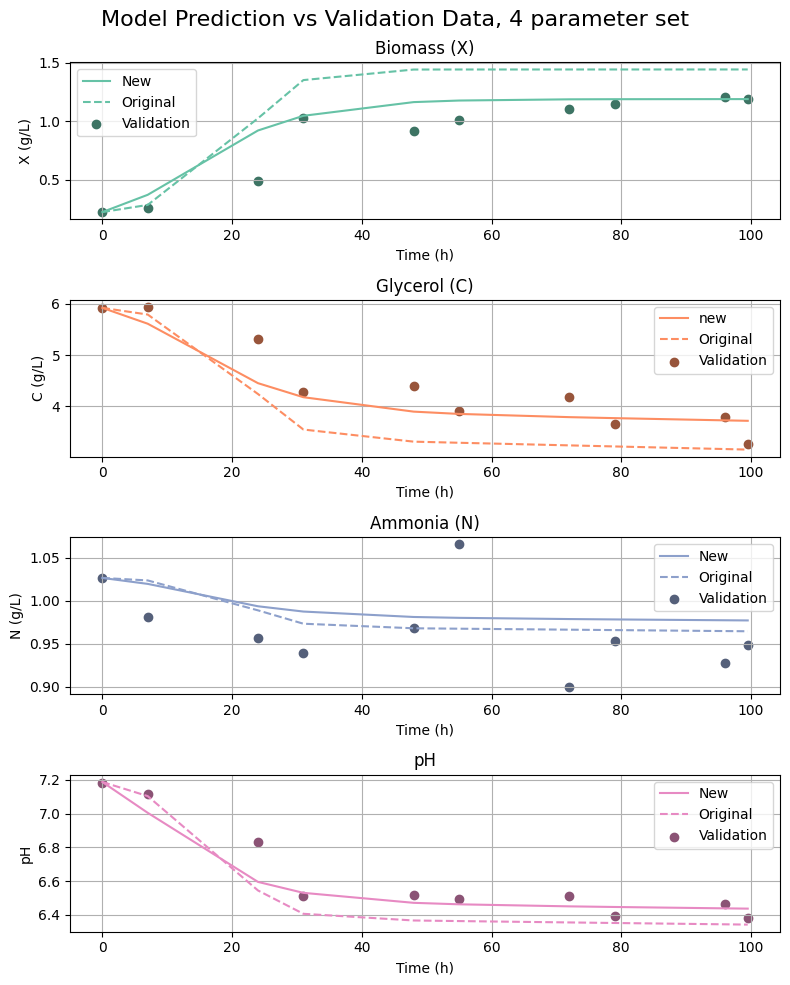

In [85]:
sol = simulate_model(p_norm, x0, params_values)
sol1 = simulate_model(P_og, x0, params_values)

best_sim = sol['xf'].full().T  
solz = sol['zf'].full().T  
best_sim1 = sol1['xf'].full().T  
solz1 = sol1['zf'].full().T  

colors = {
    'X': '#66C2A6',
    'C': '#FD8D62',
    'N': '#8DA0CB',
    'CO2': '#FED92F',
    'O2': '#A7D854',
    'pH': '#E78AC3',
    'mu': '#B3B3B3'
}

def darken_color(color, factor=0.6):
    rgb = mcolors.to_rgb(color)
    return tuple(factor * c for c in rgb)

fig, axes = plt.subplots(4, 1, figsize=(8, 10))

t_casadi_O2 = np.linspace(0, 80, 501)
# Biomass
axes[0].plot(t_exp, best_sim[:, 0], label='New', color=colors['X'])
axes[0].plot(t_exp, best_sim1[:, 0] ,'--',label='Original', color=colors['X'])
axes[0].scatter(t_exp, X_exp_v, label='Validation', color=darken_color(colors['X']), marker='o')
axes[0].set_title('Biomass (X)')
axes[0].set_xlabel('Time (h)')
axes[0].set_ylabel('X (g/L)')
axes[0].grid(True)
axes[0].legend()

# Glycerol
axes[1].plot(t_exp, best_sim[:, 1], label='new', color=colors['C'])
axes[1].plot(t_exp, best_sim1[:, 1] ,'--',label='Original', color=colors['C'])
axes[1].scatter(t_exp, C_exp_v, label='Validation', color=darken_color(colors['C']), marker='o')
axes[1].set_title('Glycerol (C)')
axes[1].set_xlabel('Time (h)')
axes[1].set_ylabel('C (g/L)')
axes[1].grid(True)
axes[1].legend()

# Ammonia
axes[2].plot(t_exp, best_sim[:, 2], label='New', color=colors['N'])
axes[2].plot(t_exp, best_sim1[:, 2] ,'--',label='Original', color=colors['N'])
axes[2].scatter(t_exp, N_exp_v, label='Validation', color=darken_color(colors['N']), marker='o')
axes[2].set_title('Ammonia (N)')
axes[2].set_xlabel('Time (h)')
axes[2].set_ylabel('N (g/L)')
axes[2].grid(True)
axes[2].legend()

# pH
axes[3].plot(t_exp, solz[:, 0], label='New', color=colors['pH'])
axes[3].plot(t_exp, solz1[:, 0] ,'--',label='Original', color=colors['pH'])
axes[3].scatter(t_exp, ph_exp_v, label='Validation', color=darken_color(colors['pH']), marker='o')
axes[3].set_title('pH')
axes[3].set_xlabel('Time (h)')
axes[3].set_ylabel('pH')
axes[3].grid(True)
axes[3].legend()

fig.suptitle('Model Prediction vs Validation Data, 4 parameter set', fontsize=16)
plt.tight_layout()
plt.show()


In [86]:
import numpy as np


X_exp = X_exp_v    
C_exp = C_exp_v
N_exp = N_exp_v
pH_exp = ph_exp_v


X_sim = best_sim[:, 0]
C_sim = best_sim[:, 1]
N_sim = best_sim[:, 2]
pH_sim = solz[:, 0]


y_exp = np.concatenate([X_exp, C_exp, N_exp, pH_exp])
y_sim = np.concatenate([X_sim, C_sim, N_sim, pH_sim])
y_sim_og = np.concatenate([best_sim1[:, 0], best_sim1[:, 1], best_sim1[:, 2], solz1[:, 0]])



n = len(y_exp)
k = len(param_names)  

NMRSE_norm = []
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def nrmse(y_true, y_pred):
    return rmse(y_true, y_pred) / (np.max(y_true) - np.min(y_true))  

#RMSE, MAPE y NRMSE por variable
print("\nMétricas por variable (nuevo modelo):")
for label, y_e, y_s in zip(['X', 'C', 'N', 'pH'], [X_exp, C_exp, N_exp, pH_exp], [X_sim, C_sim, N_sim, pH_sim]):
    print(f"{label}:")
    print(f"  RMSE:   {rmse(y_e, y_s):.4f}")
    print(f"  NRMSE:  {nrmse(y_e, y_s):.4f}")
    print(f"  MAPE:   {mape(y_e, y_s):.2f} %")
    NMRSE_norm.append(nrmse(y_e, y_s))


#RMSE, MAPE y NRMSE por variable (modelo original)
print("\nMétricas por variable (modelo original):")
for label, y_e, y_s in zip(['X', 'C', 'N', 'pH'], [X_exp, C_exp, N_exp, pH_exp], 
                                        [best_sim1[:, 0], best_sim1[:, 1], best_sim1[:, 2], solz1[:, 0]]):
    print(f"{label}:")
    print(f"  RMSE:   {rmse(y_e, y_s):.4f}")
    print(f"  NRMSE:  {nrmse(y_e, y_s):.4f}")
    print(f"  MAPE:   {mape(y_e, y_s):.2f} %")

#Métricas globales
rss = np.sum((y_exp - y_sim)**2)
rss_og = np.sum((y_exp - y_sim_og)**2)

aic_new = 2 * k + n * np.log(rss / n)
bic_new = k * np.log(n) + n * np.log(rss / n)

aic_og = 2 * k + n * np.log(rss_og / n)
bic_og = k * np.log(n) + n * np.log(rss_og / n)

print("\nMétricas globales:")
print(f"AIC (nuevo modelo): {aic_new:.2f}")
print(f"BIC (nuevo modelo): {bic_new:.2f}")
print(f"AIC (modelo original): {aic_og:.2f}")
print(f"BIC (modelo original): {bic_og:.2f}")
print(f"RMSE (nuevo modelo): {rmse(y_exp, y_sim):.4f}")
print(f"RMSE (modelo original): {rmse(y_exp, y_sim_og):.4f}")
print(f"NMRSE (nuevo modelo): {nrmse(y_exp, y_sim):.4f}")
print(f"NMRSE (modelo original): {nrmse(y_exp, y_sim_og):.4f}")
print(f"MAPE (nuevo modelo): {mape(y_exp, y_sim):.2f} %")
print(f"MAPE (modelo original): {mape(y_exp, y_sim_og):.2f} %")








Métricas por variable (nuevo modelo):
X:
  RMSE:   0.1737
  NRMSE:  0.1770
  MAPE:   19.36 %
C:
  RMSE:   0.3854
  NRMSE:  0.1444
  MAPE:   6.52 %
N:
  RMSE:   0.0477
  NRMSE:  0.2876
  MAPE:   4.19 %
pH:
  RMSE:   0.0897
  NRMSE:  0.1121
  MAPE:   0.95 %

Métricas por variable (modelo original):
X:
  RMSE:   0.3441
  NRMSE:  0.3507
  MAPE:   35.18 %
C:
  RMSE:   0.6909
  NRMSE:  0.2589
  MAPE:   13.51 %
N:
  RMSE:   0.0445
  NRMSE:  0.2685
  MAPE:   3.50 %
pH:
  RMSE:   0.1319
  NRMSE:  0.1648
  MAPE:   1.58 %

Métricas globales:
AIC (nuevo modelo): -118.09
BIC (nuevo modelo): -114.71
AIC (modelo original): -70.89
BIC (modelo original): -67.51
RMSE (nuevo modelo): 0.2174
RMSE (modelo original): 0.3922
NMRSE (nuevo modelo): 0.0312
NMRSE (modelo original): 0.0563
MAPE (nuevo modelo): 7.76 %
MAPE (modelo original): 13.44 %


# comparacion de modelos

In [87]:
# Original parameters
params_og = {
      't_lag': 7,
      'k_C': 0.3828,
      'k_N': 1.0027e-4, 
      'Y': {'X_C': 0.484,
      'X_N': 21.575, 
      'X_CO2': 0.3687}, 
      'Xmax': 1.4462,
      'mu_max': 0.19,
      'k_d': 0.001, 
      'pH': {'pka1': 6.86, # pKa of KH2PO4
            'pka2': 3.13,  # pka of C6H8O7
            'pka3': 4.76,  # pka of (C6H7O7)-
            'pka4': 6.40,  # pka of (C6H6O7)2-
            'pka5': 9.25,  # pka of NH3
            'pka6': 14.15, # pka of C3H8O3
            'pka7': 6.35,  # pka of CO2
            'pka8': 10.33, # pka of (HCO3)-
            'pka9': 14,    # pka of H2O
            'conc': {'KH2PO4': 2.18,
                  'C6H8O7': 2},
            'LL': 3.4687,
            'UL': 7.4,
            'alk': 7.2},
      'I_val': 4.0413,
      'pH_M': [0, 14]} 

# Parameters for saturated oxygen
params_oxygen = copy.deepcopy(params_og)
params_oxygen['Y']['X_O2'] = 1.352
params_oxygen['O2_sat'] = 0.007267
params_oxygen['k_La'] = 86.26
params_oxygen['k_O'] = 0.0045  

# Parameters for hypoxia
params_hypoxia = copy.deepcopy(params_og)
params_hypoxia['Y']['X_O2'] = 1.352
params_hypoxia['O2_sat'] = 0.007267
params_hypoxia['k_La'] = 5
params_hypoxia['k_O'] = 0.0045  

In [88]:
# Experimental data

df_exp_v = pd.read_excel('Experimental_data.xlsx', sheet_name='Validation Data')
t_exp = df_exp_v['Time (hours)']
t_exp_v = df_exp_v['Time (hours)']
X_exp_v = df_exp_v['Biomass (g/L)']
C_exp_v = df_exp_v['Glycerol (g/L)']
N_exp_v = df_exp_v['Ammonia (g/L)']
ph_exp_v = df_exp_v['pH']


# Initial conditions
X0 = X_exp_v[0]
c0 = C_exp_v[0]
n0 = N_exp_v[0]
co20 = 0.439 / 1000
o20 = 0.0001
z0 = ph_exp[0]  
x0 = np.array([X0, c0, n0, co20, o20, z0])

t_exp = np.linspace(0, 100, 501)
sol = simulate_model(p_norm, x0, params_values)

best_sim = sol['xf'].full().T  
solz = sol['zf'].full().T 

mu_values_casadi_adjusted = np.zeros_like(best_sim[:, 4])
for i in range(len(best_sim[:, 1])):
    mu_values_casadi_adjusted[i] = (
        p_norm[0] *
        (1 - np.exp(-t_exp[i] / params_values['t_lag'])) *
        (best_sim[:, 1][i] / (best_sim[:, 1][i] + params_values['k_C'])) *
        (best_sim[:, 2][i] / (best_sim[:, 2][i] + params_values['k_N'])) *
        (best_sim[:, 4][i] / (best_sim[:, 4][i] + params_values['k_O'])) *
        np.exp((params_og['I_val'] *
               (solz[:, 0][i] - p_norm[0]) /
               (p_norm[0] - params_og['pH']['LL'])) ** 2) *
        (1 - best_sim[:, 0][i] / p_norm[1])
    )

## OG model

In [89]:
def DAE_system_CasADi_OG(t, vars, z_algebraic, params):

    # Unpack variables
    X, C, N, CO2 = vars[0], vars[1], vars[2], vars[3]
    w = z_algebraic[0] # pH

    # Explicit algebraic equations
    # pH inhibition factor
    Iph = ca.exp((params['I_val'] * ((w - params['pH']['UL']) / (params['pH']['UL'] - params['pH']['LL']))) ** 2)

    # Specific growth rate
    mu = (params['mu_max'] 
          * (1 - ca.exp(-t / params['t_lag'])) 
          * (C / (C + params['k_C'])) 
          * (N / (N + params['k_N'])) 
          * (1 - (X / (params['Xmax']))) 
          * Iph)
    
    ka7 = 10 ** (-params['pH']['pka7'])
    
    # Differential equations
    dXdt   = (mu- params['k_d']) * X                                                     # Biomass
    dCdt   = - (mu / params['Y']['X_C']) * X                                             # Glycerol
    dNdt   = - (mu / params['Y']['X_N']) * X                                             # Ammonia
    dCO2dt = ((mu / params['Y']['X_CO2']) * X) - ka7 * (CO2 / (((10 ** -w) / ka7) + 1))  # CO2

    return ca.vertcat(dXdt, dCdt, dNdt, dCO2dt)

In [90]:
# Symbolic variables
t = ca.MX.sym('t')
x = ca.MX.sym('x', 4)  # [X, C, N, CO2]
z = ca.MX.sym('z')     # [pH]

# Systems's differential equations
dxdt = DAE_system_CasADi_OG(t, x, z, params_og)

# Algebraic equation
# Parameters
ka1 = 10 ** (-params_oxygen['pH']['pka1'])  # KH2PO4
ka2 = 10 ** (-params_oxygen['pH']['pka2'])  # C6H8O7
ka3 = 10 ** (-params_oxygen['pH']['pka3'])  # (C6H7O7)-
ka4 = 10 ** (-params_oxygen['pH']['pka4'])  # (C6H6O7)2-
ka7 = 10 ** (-params_oxygen['pH']['pka7'])  # CO2
ka9 = 10 ** (-params_oxygen['pH']['pka9'])  # H2O

H = 10 ** (-z) 

# Concentration of charges according to H+ ions
KHPO4 = params_oxygen['pH']['conc']['KH2PO4'] / ((H / ka1) + 1)
C6H5O7 = params_oxygen['pH']['conc']['C6H8O7'] / ((H ** 3 / (ka2 * ka3 * ka4)) + (H ** 2 / (ka3 * ka4)) + (H / ka4) + 1)
C6H6O7 = (H / ka4) * C6H5O7
C6H7O7 = (H / ka3) * C6H6O7
HCO3 = x[3] / ((H / ka7) + 1)
OH = ka9 / H

f_z = OH + HCO3 + KHPO4 + (3 * C6H5O7) + (2 * C6H6O7) + C6H7O7 - params_oxygen['pH']['alk'] - H

# CasADi function
f = ca.Function('f', [t, x, z], [dxdt])

In [91]:
# Initial conditions
X0 = 0.223
c0 = 5.922
n0 = 1.027
co20 = 0.439 / 1000
x0 = np.array([X0, c0, n0, co20])

z0 = np.array([0.0])  


tf = 100
n_steps = 500

t_values = np.linspace(0, tf, n_steps + 1)

# ODE system
dae = {'t': t, 'x': x, 'z': z, 'ode': f(t, x, z), 'alg': f_z}
integrator = ca.integrator('integrator', 'idas', dae, {'grid': t_values, 'output_t0': True})

# Solve
sol_casadi_OG = integrator(x0=x0, z0=z0)

In [92]:
# Extract results
t_casadi_og = np.linspace(0, 100, 501)
x_final_og = sol_casadi_OG['xf'].full().T
z_final_og = sol_casadi_OG['zf'].full().T

X_casadi_og = x_final_og[:, 0]
C_casadi_og = x_final_og[:, 1]
N_casadi_og = x_final_og[:, 2]
CO2_casadi_og = x_final_og[:, 3]
pH_casadi_og = z_final_og[:, 0]

# Compute specific growth rate over time
mu_values_casadi_og = np.zeros_like(C_casadi_og)
for i in range(len(C_casadi_og)):
    mu_values_casadi_og[i] = (
        params_og['mu_max'] *
        (1 - np.exp(-t_casadi_og[i] / params_og['t_lag'])) *
        (C_casadi_og[i] / (C_casadi_og[i] + params_og['k_C'])) *
        (N_casadi_og[i] / (N_casadi_og[i] + params_og['k_N'])) *
        np.exp((params_og['I_val'] *
               (pH_casadi_og[i] - params_og['pH']['UL']) /
               (params_og['pH']['UL'] - params_og['pH']['LL'])) ** 2) *
        (1 - X_casadi_og[i] / params_og['Xmax'])
    )

## Saturated Oxygen

In [93]:
def DAE_system_CasADi_O2(t, vars, z_algebraic, params):

    # Unpack variables
    X, C, N, CO2, O = vars[0], vars[1], vars[2], vars[3], vars[4]
    w = z_algebraic[0] # pH

    # Explicit algebraic equations
    # pH inhibition factor
    Iph = ca.exp((params['I_val'] * ((w - params['pH']['UL']) / (params['pH']['UL'] - params['pH']['LL']))) ** 2)

    # Specific growth rate
    mu = (params['mu_max'] 
          * (1 - ca.exp(-t / params['t_lag'])) 
          * (C / (C + params['k_C'])) 
          * (N / (N + params['k_N'])) 
          * (O / (O + params['k_O']))
          * (1 - (X / (params['Xmax']))) 
          * Iph)
    
    ka7 = 10 ** (-params['pH']['pka7'])
    
    # Differential equations
    dXdt   = (mu- params['k_d']) * X                                                     # Biomass
    dCdt   = - (mu / params['Y']['X_C']) * X                                             # Glycerol
    dNdt   = - (mu / params['Y']['X_N']) * X                                             # Ammonia
    dCO2dt = ((mu / params['Y']['X_CO2']) * X) - ka7 * (CO2 / (((10 ** -w) / ka7) + 1))  # CO2
    dOdt   = params['k_La'] * (params['O2_sat'] - O) - (mu / params['Y']['X_O2']) * X    # O2

    return ca.vertcat(dXdt, dCdt, dNdt, dCO2dt, dOdt)

In [94]:
# Symbolic variables
t = ca.MX.sym('t')
x = ca.MX.sym('x', 5)  # [X, C, N, CO2, O2]
z = ca.MX.sym('z')     # [pH]

# Systems's differential equations
dxdt = DAE_system_CasADi_O2(t, x, z, params_oxygen)

# Algebraic equation
# Parameters
ka1 = 10 ** (-params_oxygen['pH']['pka1'])  # KH2PO4
ka2 = 10 ** (-params_oxygen['pH']['pka2'])  # C6H8O7
ka3 = 10 ** (-params_oxygen['pH']['pka3'])  # (C6H7O7)-
ka4 = 10 ** (-params_oxygen['pH']['pka4'])  # (C6H6O7)2-
ka7 = 10 ** (-params_oxygen['pH']['pka7'])  # CO2
ka9 = 10 ** (-params_oxygen['pH']['pka9'])  # H2O

H = 10 ** (-z) 

# Concentration of charges according to H+ ions
KHPO4 = params_oxygen['pH']['conc']['KH2PO4'] / ((H / ka1) + 1)
C6H5O7 = params_oxygen['pH']['conc']['C6H8O7'] / ((H ** 3 / (ka2 * ka3 * ka4)) + (H ** 2 / (ka3 * ka4)) + (H / ka4) + 1)
C6H6O7 = (H / ka4) * C6H5O7
C6H7O7 = (H / ka3) * C6H6O7
HCO3 = x[3] / ((H / ka7) + 1)
OH = ka9 / H

f_z = OH + HCO3 + KHPO4 + (3 * C6H5O7) + (2 * C6H6O7) + C6H7O7 - params_oxygen['pH']['alk'] - H

# CasADi function
f_O2 = ca.Function('f', [t, x, z], [dxdt])

In [95]:
# Initial conditions
X0 = 0.223
c0 = 5.922
n0 = 1.027
co20 = 0.439 / 1000
o20 = params_oxygen['O2_sat']
x0 = np.array([X0, c0, n0, co20, o20])

z0 = np.array([0.0])  # Initial guess for pH

# Final time and number of integration steps
tf = 100
n_steps = 500

# Simulation time vector
t_values = np.linspace(0, tf, n_steps + 1)

# ODE system
dae = {'t': t, 'x': x, 'z': z, 'ode': f_O2(t,x,z), 'alg': f_z}
integrator_O2 = ca.integrator('integrator', 'idas', dae, {'grid': t_values, 'output_t0': True})

# Solve
sol_casadi_O2 = integrator_O2(x0=x0, z0=z0)

In [96]:
# Extract results
t_casadi_O2 = np.linspace(0, 100, 501)
x_final_O2 = sol_casadi_O2['xf'].full().T
z_final_O2 = sol_casadi_O2['zf'].full().T

X_casadi_O2 = x_final_O2[:, 0]
C_casadi_O2 = x_final_O2[:, 1]
N_casadi_O2 = x_final_O2[:, 2]
CO2_casadi_O2 = x_final_O2[:, 3]
O2_casadi_O2 = x_final_O2[:, 4]
pH_casadi_O2 = z_final_O2[:, 0]

# Compute specific growth rate over time
mu_values_casadi_O2 = np.zeros_like(C_casadi_O2)
for i in range(len(C_casadi_O2)):
    mu_values_casadi_O2[i] = (
        params_oxygen['mu_max'] *
        (1 - np.exp(-t_casadi_O2[i] / params_oxygen['t_lag'])) *
        (C_casadi_O2[i] / (C_casadi_O2[i] + params_oxygen['k_C'])) *
        (N_casadi_O2[i] / (N_casadi_O2[i] + params_oxygen['k_N'])) *
        (O2_casadi_O2[i] / (O2_casadi_O2[i] + params_oxygen['k_O'])) *
        np.exp((params_oxygen['I_val'] *
               ((pH_casadi_O2[i] - params_oxygen['pH']['UL']) /
               (params_oxygen['pH']['UL'] - params_oxygen['pH']['LL']))) ** 2) *
        (1 - X_casadi_O2[i] / params_oxygen['Xmax'])
    )

## Original Model vs O2 Model

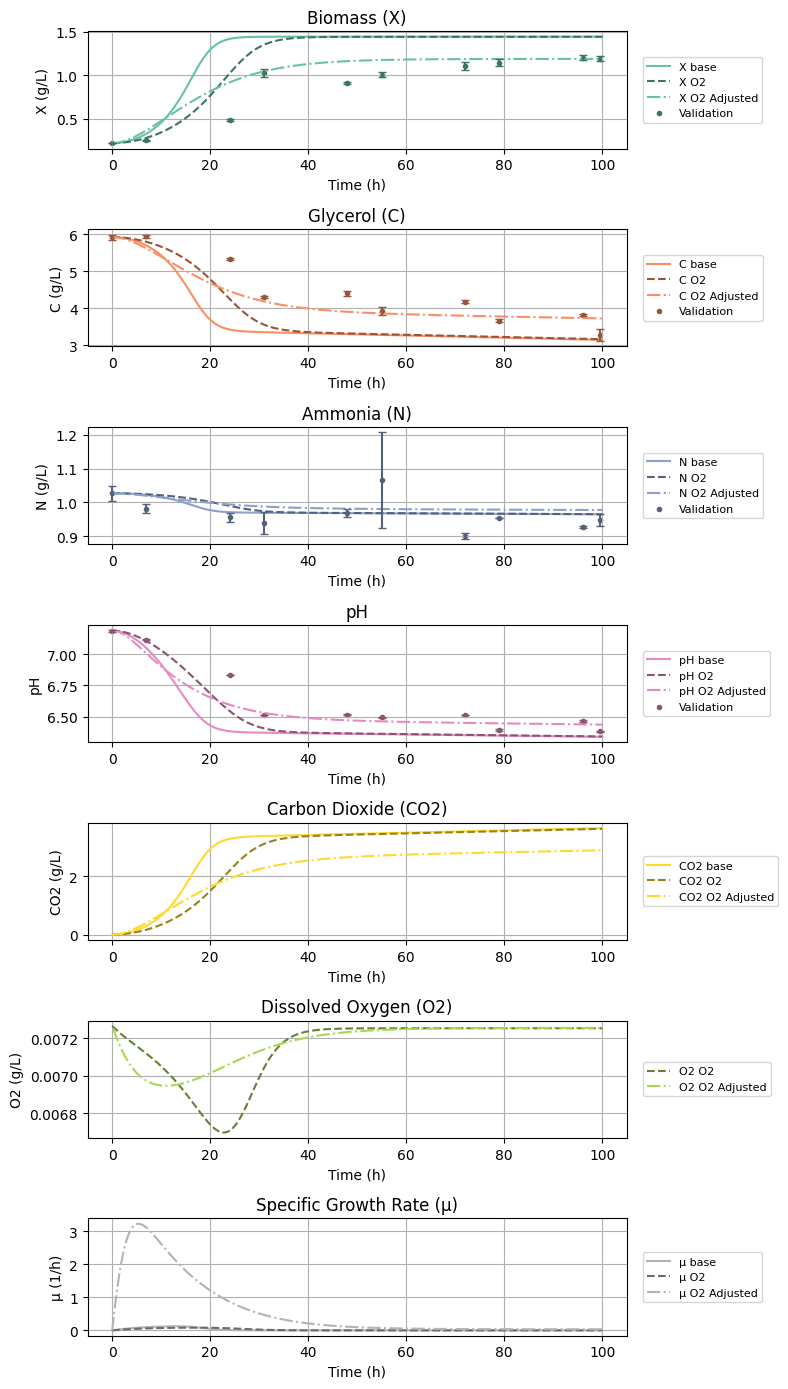

In [97]:

colors = {
    'X': '#66C2A6',
    'C': '#FD8D62',
    'N': '#8DA0CB',
    'CO2': '#FED92F',
    'O2': '#A7D854',
    'pH': '#E78AC3',
    'mu': '#B3B3B3'
}

def darken_color(color, factor=0.6):
    rgb = mcolors.to_rgb(color)
    return tuple(factor * c for c in rgb)

fig, axes = plt.subplots(7, 1, figsize=(8, 14))

axes[0].plot(t_casadi_og, X_casadi_og, label='X base', color=colors['X'])
axes[0].plot(t_casadi_O2, X_casadi_O2, '--', label='X O2', color=darken_color(colors['X']))
axes[0].plot(t_exp, best_sim[:, 0],'-.', label='X O2 Adjusted', color=colors['X'])
axes[0].scatter(t_exp_v, X_exp_v, label='Validation', color=darken_color(colors['X']), marker='.')
axes[0].errorbar(t_exp_v, X_exp_v, yerr=X_err, fmt='.', color=darken_color(colors['X']), markersize=2, capsize=3)
axes[0].set_title('Biomass (X)')
axes[0].set_xlabel('Time (h)')
axes[0].set_ylabel('X (g/L)')
axes[0].grid(True)
axes[0].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[1].plot(t_casadi_og, C_casadi_og, label='C base', color=colors['C'])
axes[1].plot(t_casadi_O2, C_casadi_O2, '--', label='C O2', color=darken_color(colors['C']))
axes[1].plot(t_exp, best_sim[:, 1],'-.', label='C O2 Adjusted', color=colors['C'])
axes[1].scatter(t_exp_v, C_exp_v, label='Validation', color=darken_color(colors['C']), marker='.')
axes[1].errorbar(t_exp_v, C_exp_v, yerr=C_err, fmt='.', color=darken_color(colors['C']), markersize=2, capsize=3)
axes[1].set_title('Glycerol (C)')
axes[1].set_xlabel('Time (h)')
axes[1].set_ylabel('C (g/L)')
axes[1].grid(True)
axes[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[2].plot(t_casadi_og, N_casadi_og, label='N base', color=colors['N'])
axes[2].plot(t_casadi_O2, N_casadi_O2, '--', label='N O2', color=darken_color(colors['N']))
axes[2].plot(t_exp, best_sim[:, 2],'-.', label='N O2 Adjusted', color=colors['N'])
axes[2].scatter(t_exp_v, N_exp_v, label='Validation', color=darken_color(colors['N']), marker='.')
axes[2].errorbar(t_exp_v, N_exp_v, yerr=N_err, fmt='.', color=darken_color(colors['N']), markersize=2, capsize=3)
axes[2].set_title('Ammonia (N)')
axes[2].set_xlabel('Time (h)')
axes[2].set_ylabel('N (g/L)')
axes[2].grid(True)
axes[2].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[4].plot(t_casadi_og, CO2_casadi_og, label='CO2 base', color=colors['CO2'])
axes[4].plot(t_casadi_O2, CO2_casadi_O2, '--', label='CO2 O2', color=darken_color(colors['CO2']))
axes[4].plot(t_exp, best_sim[:, 3],'-.', label='CO2 O2 Adjusted', color=colors['CO2'])
axes[4].set_title('Carbon Dioxide (CO2)')
axes[4].set_xlabel('Time (h)')
axes[4].set_ylabel('CO2 (g/L)')
axes[4].grid(True)
axes[4].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[5].plot(t_casadi_O2, O2_casadi_O2, '--', label='O2 O2', color=darken_color(colors['O2']))
axes[5].plot(t_exp[1:], best_sim[1:,4],'-.', label='O2 O2 Adjusted', color=colors['O2'])
axes[5].set_title('Dissolved Oxygen (O2)')
axes[5].set_xlabel('Time (h)')
axes[5].set_ylabel('O2 (g/L)')
axes[5].grid(True)
axes[5].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[3].plot(t_casadi_og, pH_casadi_og, label='pH base', color=colors['pH'])
axes[3].plot(t_casadi_O2, pH_casadi_O2, '--', label='pH O2', color=darken_color(colors['pH']))
axes[3].plot(t_exp, solz[:, 0],'-.', label='pH O2 Adjusted', color=colors['pH'])
axes[3].scatter(t_exp_v, ph_exp_v, label='Validation', color=darken_color(colors['pH']), marker='.')
axes[3].errorbar(t_exp_v, ph_exp_v, yerr=ph_err, fmt='.', color=darken_color(colors['pH']), markersize=2, capsize=3)
axes[3].set_title('pH')
axes[3].set_xlabel('Time (h)')
axes[3].set_ylabel('pH')
axes[3].grid(True)
axes[3].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[6].plot(t_casadi_og, mu_values_casadi_og, label='μ base', color=colors['mu'])
axes[6].plot(t_casadi_O2, mu_values_casadi_O2, '--', label='μ O2', color=darken_color(colors['mu']))
axes[6].plot(t_exp, mu_values_casadi_adjusted, '-.', label='μ O2 Adjusted', color=(colors['mu']))
axes[6].set_title('Specific Growth Rate (μ)')
axes[6].set_xlabel('Time (h)')
axes[6].set_ylabel('μ (1/h)')
axes[6].grid(True)
axes[6].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

#fig.suptitle('Comparison between models', fontsize=16)
plt.tight_layout()
plt.savefig('Figures/model_comparison_highres.png', dpi=500, bbox_inches='tight')
plt.show()


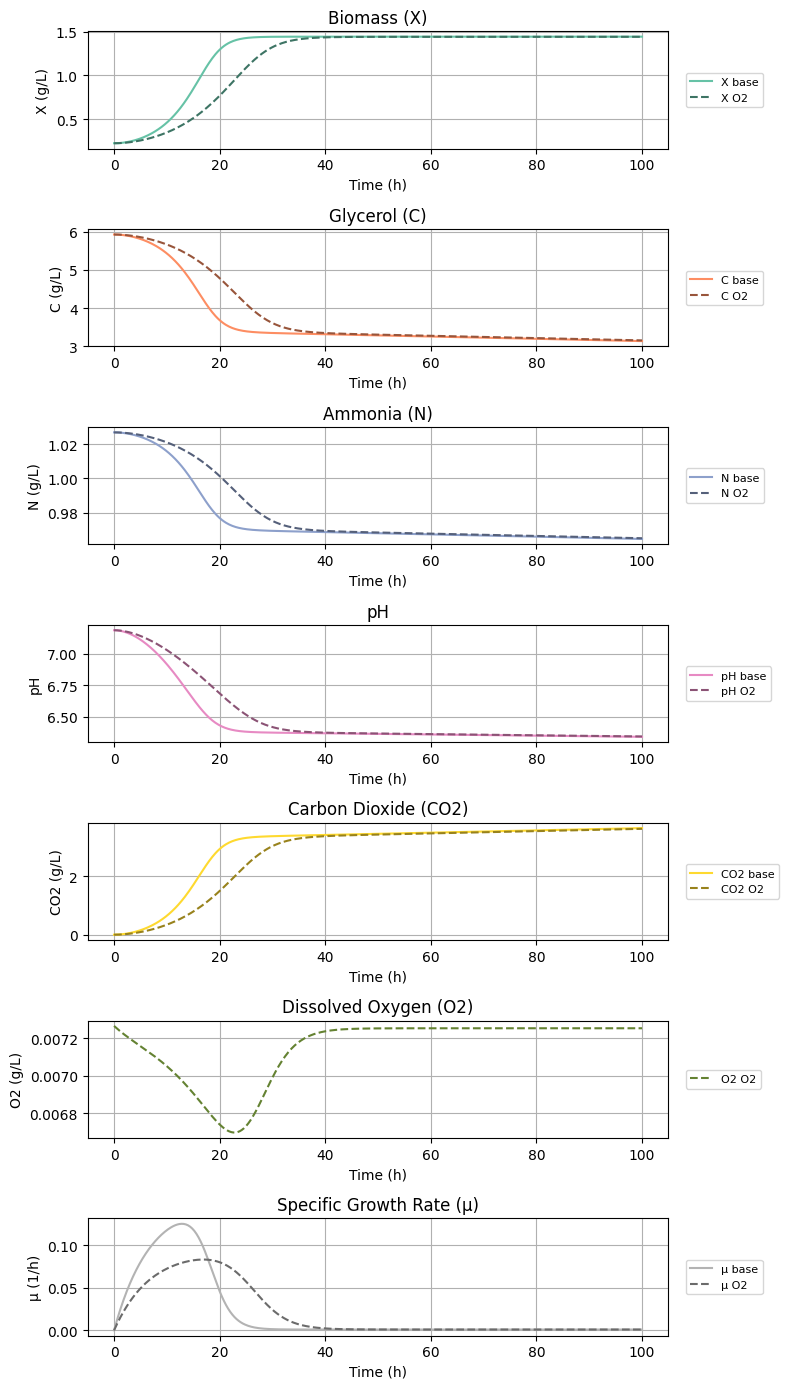

In [98]:
colors = {
    'X': '#66C2A6',
    'C': '#FD8D62',
    'N': '#8DA0CB',
    'CO2': '#FED92F',
    'O2': '#A7D854',
    'pH': '#E78AC3',
    'mu': '#B3B3B3'
}

def darken_color(color, factor=0.6):
    rgb = mcolors.to_rgb(color)
    return tuple(factor * c for c in rgb)

fig, axes = plt.subplots(7, 1, figsize=(8, 14))

axes[0].plot(t_casadi_og, X_casadi_og, label='X base', color=colors['X'])
axes[0].plot(t_casadi_O2, X_casadi_O2, '--', label='X O2', color=darken_color(colors['X']))
axes[0].set_title('Biomass (X)')
axes[0].set_xlabel('Time (h)')
axes[0].set_ylabel('X (g/L)')
axes[0].grid(True)
axes[0].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[1].plot(t_casadi_og, C_casadi_og, label='C base', color=colors['C'])
axes[1].plot(t_casadi_O2, C_casadi_O2, '--', label='C O2', color=darken_color(colors['C']))
axes[1].set_title('Glycerol (C)')
axes[1].set_xlabel('Time (h)')
axes[1].set_ylabel('C (g/L)')
axes[1].grid(True)
axes[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[2].plot(t_casadi_og, N_casadi_og, label='N base', color=colors['N'])
axes[2].plot(t_casadi_O2, N_casadi_O2, '--', label='N O2', color=darken_color(colors['N']))
axes[2].set_title('Ammonia (N)')
axes[2].set_xlabel('Time (h)')
axes[2].set_ylabel('N (g/L)')
axes[2].grid(True)
axes[2].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[4].plot(t_casadi_og, CO2_casadi_og, label='CO2 base', color=colors['CO2'])
axes[4].plot(t_casadi_O2, CO2_casadi_O2, '--', label='CO2 O2', color=darken_color(colors['CO2']))
axes[4].set_title('Carbon Dioxide (CO2)')
axes[4].set_xlabel('Time (h)')
axes[4].set_ylabel('CO2 (g/L)')
axes[4].grid(True)
axes[4].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[5].plot(t_casadi_O2, O2_casadi_O2, '--', label='O2 O2', color=darken_color(colors['O2']))
axes[5].set_title('Dissolved Oxygen (O2)')
axes[5].set_xlabel('Time (h)')
axes[5].set_ylabel('O2 (g/L)')
axes[5].grid(True)
axes[5].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[3].plot(t_casadi_og, pH_casadi_og, label='pH base', color=colors['pH'])
axes[3].plot(t_casadi_O2, pH_casadi_O2, '--', label='pH O2', color=darken_color(colors['pH']))
axes[3].set_title('pH')
axes[3].set_xlabel('Time (h)')
axes[3].set_ylabel('pH')
axes[3].grid(True)
axes[3].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

axes[6].plot(t_casadi_og, mu_values_casadi_og, label='μ base', color=colors['mu'])
axes[6].plot(t_casadi_O2, mu_values_casadi_O2, '--', label='μ O2', color=darken_color(colors['mu']))
axes[6].set_title('Specific Growth Rate (μ)')
axes[6].set_xlabel('Time (h)')
axes[6].set_ylabel('μ (1/h)')
axes[6].grid(True)
axes[6].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

#fig.suptitle('Comparison between models', fontsize=16)
plt.tight_layout()
plt.savefig('Figures/model_comparison_wo2.png', dpi=500, bbox_inches='tight')
plt.show()